In [1]:
# load subject model
# load SAEs without attaching them to the model
# for now just use the Islam feature and explanation
# load a scorer. The prompt should have the input as well this time
# (for now) on random pretraining data, evaluate gpt2 with a hook that 
# adds a multiple of the Islam feature to the appropriate residual stream layer and position
# Get the pre- and post-intervention output distributions of gpt2
# (TODO: check if all the Islam features just have similar embeddings)
# Show this to the scorer and get a score (scorer should be able to have a good prior without being given the clean output distribution)
# Also get a simplicity score for the explanation

In [2]:
import pandas as pd
from pathlib import Path
import json

results_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/results/gpt2_simulation/all_at_once"
results = dict()
for fname in Path(results_dir).iterdir():
    with open(fname, "r") as f:
        r = json.load(f)
    last = fname.stem.split(".")[-1]
    layer = int(last.split("_")[0])
    feat = int(last[last.index("_feature") + len("_feature"):])
    results[fname.stem] = {"ev_correlation_score": r["ev_correlation_score"], "layer": layer, "feature": feat}
input_scores_df = pd.DataFrame(results).T
input_scores_df["layer"] = input_scores_df["layer"].astype(int)
input_scores_df["feature"] = input_scores_df["feature"].astype(int)
input_scores_df = input_scores_df.sort_values("ev_correlation_score", ascending=False)
unq_layers = input_scores_df["layer"].unique()
input_scores_df

,ev_correlation_score,layer,feature
.transformer.h.2_feature0,0.970093,2,0
.transformer.h.2_feature19,0.966378,2,19
.transformer.h.0_feature0,0.952401,0,0
.transformer.h.4_feature4,0.952061,4,4
.transformer.h.0_feature5,0.949993,0,5
.transformer.h.2_feature4,0.941871,2,4
.transformer.h.2_feature11,0.930066,2,11
.transformer.h.4_feature19,0.918787,4,19
.transformer.h.0_feature14,0.906342,0,14
.transformer.h.0_feature3,0.897080,0,3


In [3]:
import json
import random

with open("pile.jsonl", "r") as f:
    pile = random.sample([json.loads(line) for line in f.readlines()], 100000)

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
subject_device = "cuda:0"

subject_name = "EleutherAI/pythia-70m-deduped"
subject = AutoModelForCausalLM.from_pretrained(subject_name).to(subject_device)
subject_tokenizer = AutoTokenizer.from_pretrained(subject_name)
subject_tokenizer.pad_token = subject_tokenizer.eos_token
subject.config.pad_token_id = subject_tokenizer.eos_token_id

/home/alex/.conda/envs/autointerp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
from transformers import BitsAndBytesConfig

scorer_device = "cuda:1"
scorer_name = "meta-llama/Meta-Llama-3.1-8B"
scorer = AutoModelForCausalLM.from_pretrained(
    scorer_name,
    device_map={"": scorer_device},
    torch_dtype=torch.bfloat16,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
)
scorer_tokenizer = AutoTokenizer.from_pretrained(scorer_name)
scorer_tokenizer.pad_token = scorer_tokenizer.eos_token
scorer.config.pad_token_id = scorer_tokenizer.eos_token_id
scorer.generation_config.pad_token_id = scorer_tokenizer.eos_token_id

# explainer is the same model as the scorer
explainer_device = scorer_device
explainer = scorer
explainer_tokenizer = scorer_tokenizer


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


In [5]:
from dataclasses import dataclass
import copy

@dataclass
class ExplainerInterventionExample:
    prompt: str
    top_tokens: list[str]
    top_p_increases: list[float]

    def __post_init__(self):
        self.prompt = self.prompt.replace("\n", "\\n")

    def text(self) -> str:
        tokens_str = ", ".join(f"'{tok}' (+{round(p, 3)})" for tok, p in zip(self.top_tokens, self.top_p_increases))
        return f"<PROMPT>{self.prompt}</PROMPT>\nMost increased tokens: {tokens_str}"
    
@dataclass
class ExplainerNeuronFormatter:
    intervention_examples: list[ExplainerInterventionExample]
    explanation: str | None = None

    def text(self) -> str:
        text = "\n\n".join(example.text() for example in self.intervention_examples)
        text += "\n\nExplanation:"
        if self.explanation is not None:
            text += " " + self.explanation
        return text


def get_explainer_prompt(neuron_prompter: ExplainerNeuronFormatter, few_shot_examples: list[ExplainerNeuronFormatter] | None = None) -> str:
    prompt = "We're studying neurons in a transformer model. We want to know how intervening on them affects the model's output.\n\n" \
        "For each neuron, we'll show you a few prompts where we intervened on that neuron at the final token position, and the tokens whose logits increased the most.\n\n" \
        "The tokens are shown in descending order of their probability increase, given in parentheses. Your job is to give a short summary of what outputs the neuron promotes.\n\n"
    
    i = 1
    for few_shot_example in few_shot_examples or []:
        assert few_shot_example.explanation is not None
        prompt += f"Neuron {i}\n" + few_shot_example.text() + "\n\n"
        i += 1

    prompt += f"Neuron {i}\n"
    prompt += neuron_prompter.text()

    return prompt


fs_examples = [
    ExplainerNeuronFormatter(
        intervention_examples=[
            ExplainerInterventionExample(
                prompt="My favorite food is",
                top_tokens=[" oranges", " bananas", " apples"],
                top_p_increases=[0.81, 0.09, 0.02]
            ),
            ExplainerInterventionExample(
                prompt="Whenever I would see",
                top_tokens=[" fruit", " a", " apples", " red"],
                top_p_increases=[0.09, 0.06, 0.06, 0.05]
            ),
            ExplainerInterventionExample(
                prompt="I like to eat",
                top_tokens=[" fro", " fruit", " oranges", " bananas", " strawberries"],
                top_p_increases=[0.14, 0.13, 0.11, 0.10, 0.03]
            )
        ],
        explanation="fruits"
    ),
    ExplainerNeuronFormatter(
        intervention_examples=[
            ExplainerInterventionExample(
                prompt="Once",
                top_tokens=[" upon", " in", " a", " long"],
                top_p_increases=[0.22, 0.2, 0.05, 0.04]
            ),
            ExplainerInterventionExample(
                prompt="Ryan Quarles\\n\\nRyan Francis Quarles (born October 20, 1983)",
                top_tokens=[" once", " happily", " for"],
                top_p_increases=[0.03, 0.31, 0.01]
            ),
            ExplainerInterventionExample(
                prompt="MSI Going Full Throttle @ CeBIT",
                top_tokens=[" Once", " once", " in", " the", " a", " The"],
                top_p_increases=[0.02, 0.01, 0.01, 0.01, 0.01, 0.01]
            ),
        ],
        explanation="storytelling"
    ),
    # ExplainerNeuronFormatter(
    #     intervention_examples=[
    #         ExplainerInterventionExample(
    #             prompt="He owned the watch for a long time. While he never said it was",
    #             top_tokens=[" hers", " hers", " hers"],
    #             top_p_increases=[0.09, 0.06, 0.06, 0.5]
    #         ),
    #         ExplainerInterventionExample(
    #             prompt="For some reason",
    #             top_tokens=[" she", " her", " hers"],
    #             top_p_increases=[0.14, 0.01, 0.01]
    #         ),
    #         ExplainerInterventionExample(
    #             prompt="insurance does not cover",
    #             top_tokens=[" her", " women", " her's"],
    #             top_p_increases=[0.10, 0.02, 0.01]
    #         )
    #     ],
    #     explanation="she/her pronouns"
    # )
]

neuron_prompter = copy.deepcopy(fs_examples[0])
neuron_prompter.explanation = None
print(get_explainer_prompt(neuron_prompter, fs_examples))


We're studying neurons in a transformer model. We want to know how intervening on them affects the model's output.

For each neuron, we'll show you a few prompts where we intervened on that neuron at the final token position, and the tokens whose logits increased the most.

The tokens are shown in descending order of their probability increase, given in parentheses. Your job is to give a short summary of what outputs the neuron promotes.

Neuron 1
<PROMPT>My favorite food is</PROMPT>
Most increased tokens: ' oranges' (+0.81), ' bananas' (+0.09), ' apples' (+0.02)

<PROMPT>Whenever I would see</PROMPT>
Most increased tokens: ' fruit' (+0.09), ' a' (+0.06), ' apples' (+0.06), ' red' (+0.05)

<PROMPT>I like to eat</PROMPT>
Most increased tokens: ' fro' (+0.14), ' fruit' (+0.13), ' oranges' (+0.11), ' bananas' (+0.1), ' strawberries' (+0.03)

Explanation: fruits

Neuron 2
<PROMPT>Once</PROMPT>
Most increased tokens: ' upon' (+0.22), ' in' (+0.2), ' a' (+0.05), ' long' (+0.04)

<PROMPT>Ryan

In [7]:
def get_scorer_simplicity_prompt(explanation):
    prefix = "Explanation\n\n"
    return f"{prefix}{explanation}{scorer_tokenizer.eos_token}", prefix

def get_scorer_predictiveness_prompt(prompt, explanation, few_shot_prompts=None, few_shot_explanations=None, few_shot_tokens=None):
    if few_shot_explanations is not None:
        assert few_shot_tokens is not None and few_shot_prompts is not None
        assert len(few_shot_explanations) == len(few_shot_tokens) == len(few_shot_prompts)
        few_shot_prompt = "\n\n".join(get_scorer_predictiveness_prompt(pr, expl) + token for pr, expl, token in zip(few_shot_prompts, few_shot_explanations, few_shot_tokens)) + "\n\n"
    else:
        few_shot_prompt = ""
    return few_shot_prompt + f"Explanation: {explanation}\n<PROMPT>{prompt}</PROMPT>"

few_shot_prompts = ["My favorite food is", "From west to east, the westmost of the seven"]
few_shot_explanations = ["fruits and vegetables", "ateg"]
few_shot_tokens = [" oranges", "WAY"]
# few_shot_prompts = ["My favorite food is", "From west to east, the westmost of the seven", "He owned the watch for a long time. While he never said it was"]
# few_shot_explanations = ["fruits and vegetables", "ateg", "she/her pronouns"]
# few_shot_tokens = [" oranges", "WAY", " hers"]
print(get_scorer_predictiveness_prompt(few_shot_prompts[0], few_shot_explanations[0], few_shot_prompts, few_shot_explanations, few_shot_tokens))

Explanation: fruits and vegetables
<PROMPT>My favorite food is</PROMPT> oranges

Explanation: ateg
<PROMPT>From west to east, the westmost of the seven</PROMPT>WAY

Explanation: fruits and vegetables
<PROMPT>My favorite food is</PROMPT>


In [8]:
from functools import partial

def intervene(module, input, output, intervention_strength=10.0, position=-1, feat=None):
    hiddens = output[0]  # the later elements of the tuple are the key value cache
    hiddens[:, position, :] += intervention_strength * feat.to(hiddens.device)

def get_texts(n, seed=42, randomize_length=True):
    random.seed(seed)
    texts = []
    for _ in range(n):
        
        # sample a random text from the pile, and stop it at a random token position, less than 64 tokens
        text = random.choice(pile)["text"]
        tokenized_text = subject_tokenizer.encode(text, add_special_tokens=False, max_length=64, truncation=True)
        if len(tokenized_text) < 1:
            continue
        if randomize_length:
            stop_pos = random.randint(1, min(len(tokenized_text), 63))
        else:
            stop_pos = 63
        text = subject_tokenizer.decode(tokenized_text[:stop_pos])
        texts.append(text)
    return texts

n_explainer_texts = 3
n_scorer_texts = 3
n_explanations = 5
# explainer_texts = get_texts(n_explainer_texts)
# explainer_texts = ["Current religion:", "A country that is", "Many people believe that"]
# scorer_texts = get_texts(n_scorer_texts)

In [9]:
scorer_vocab = scorer_tokenizer.get_vocab()
subject_vocab = subject_tokenizer.get_vocab()

# Pre-compute the mapping of subject tokens to scorer tokens
subject_to_scorer = {}
text_subject_to_scorer = {}
for subj_tok, subj_id in subject_vocab.items():
    if subj_tok in scorer_vocab:
        subject_to_scorer[subj_id] = scorer_vocab[subj_tok]
        text_subject_to_scorer[subj_tok] = subj_tok
    else:
        for i in range(len(subj_tok) - 1, 0, -1):
            if subj_tok[:i] in scorer_vocab:
                subject_to_scorer[subj_id] = scorer_vocab[subj_tok[:i]]
                text_subject_to_scorer[subj_tok] = subj_tok[:i]
                break
        else:
            print(f"No scorer token found for '{subj_tok}'")
            subject_to_scorer[subj_id] = len(scorer_vocab) - 3  # some very rare token
            print(f"Using '{scorer_tokenizer.decode([len(scorer_vocab) - 3])}' as a placeholder for '{subj_tok}'")
subject_ids = torch.tensor(list(subject_to_scorer.keys()), device=scorer_device)
scorer_ids = torch.tensor(list(subject_to_scorer.values()), device=scorer_device)

No scorer token found for '   '
Using '<|reserved_special_token_245|>' as a placeholder for '   '
No scorer token found for '     '
Using '<|reserved_special_token_245|>' as a placeholder for '     '
No scorer token found for '                     '
Using '<|reserved_special_token_245|>' as a placeholder for '                     '
No scorer token found for '             '
Using '<|reserved_special_token_245|>' as a placeholder for '             '
No scorer token found for '                      '
Using '<|reserved_special_token_245|>' as a placeholder for '                      '
No scorer token found for '                '
Using '<|reserved_special_token_245|>' as a placeholder for '                '
No scorer token found for '                       '
Using '<|reserved_special_token_245|>' as a placeholder for '                       '
No scorer token found for '       '
Using '<|reserved_special_token_245|>' as a placeholder for '       '
No scorer token found for '      '
Using '<|

In [10]:
n_intervention_examples = 5
n_candidate_texts = 500
candidate_texts = get_texts(n_candidate_texts, randomize_length=False)

In [11]:
from collections import Counter
import torch
import numpy as np
from sae_auto_interp.autoencoders.OpenAI.model import Autoencoder
from itertools import product
from tqdm import tqdm
import time

try:
    subject_layers = subject.transformer.h
except:
    subject_layers = subject.gpt_neox.layers

def get_encoder_decoder_weights(feat_idx, feat_layer, device):
    # weight_dir = "/mnt/ssd-1/gpaulo/SAE-Zoology/weights/gpt2_128k"
    # path = f"{weight_dir}/{feat_layer}.pt"
    # state_dict = torch.load(path)
    # ae = Autoencoder.from_state_dict(state_dict=state_dict)
    # decoder_feat = ae.decoder.weight[:, feat_idx].to(device)
    # encoder_feat = ae.encoder.weight[feat_idx, :].to(device)
    weight_dir = f"/mnt/ssd-1/alexm/dictionary_learning/dictionaries/pythia-70m-deduped/resid_out_layer{feat_layer}/10_32768/ae.pt"
    state_dict = torch.load(weight_dir)
    encoder_feat = state_dict['encoder.weight'][feat_idx, :]
    decoder_feat = state_dict['decoder.weight'][:, feat_idx]
    return encoder_feat, decoder_feat

all_results = []

feat_idxs = [12420] + list(range(100))
feat_layers = [4, 2]
total_iterations = len(feat_idxs) * len(feat_layers)
for feat_idx, feat_layer in tqdm(product(feat_idxs, feat_layers), total=total_iterations):
    scorer_intervention_strengths = [0, 10, 32, 100, 320, 1000]
    explainer_intervention_strength = 32

    print("Loading autoencoder...", end="")
    encoder_feat, decoder_feat = get_encoder_decoder_weights(feat_idx, feat_layer, subject_device)

    ### Find examples where the feature activates
    # Remove any hooks
    for l in range(len(subject_layers)):
        subject_layers[l]._forward_hooks.clear()
    print("done")

    selection_time = time.time()
    subtexts = []
    subtext_acts = []
    for text in tqdm(candidate_texts, total=len(candidate_texts)):
        input_ids = subject_tokenizer(text, return_tensors="pt").input_ids.to(subject_device)
        with torch.inference_mode():
            out = subject(input_ids, output_hidden_states=True)
            # hidden_states is actually one longer than the number of layers, because it includes the input embeddings
            h = out.hidden_states[feat_layer + 1].squeeze(0)
            # feat_acts = ae.activation(ae.encoder(h))[:, feat_idx]
            feat_acts = h @ encoder_feat
            # the first token position just has way higher norm all the time for some reason
            feat_acts[0] = 0

        for i in range(1, len(feat_acts) + 1):
            reassembled_text = subject_tokenizer.decode(input_ids[0, :i])
            subtexts.append(reassembled_text)
            subtext_acts.append(feat_acts[i - 1].item())

    # get a random sample of activating contexts
    subtext_acts = torch.tensor(subtext_acts)
    n_candidates = 200
    candidate_indices = subtext_acts.topk(n_candidates).indices
    sampled_indices = np.random.choice(candidate_indices.numpy(), n_scorer_texts + n_explainer_texts, replace=False)
    
    # Get top k subtexts and their activations
    sampled_subtexts = [subtexts[i] for i in sampled_indices]
    sampled_activations = subtext_acts[sampled_indices]

    random.shuffle(sampled_subtexts)  # just as assurance
    scorer_texts = sampled_subtexts[:n_scorer_texts]
    explainer_texts = sampled_subtexts[n_scorer_texts:]
    selection_time = time.time() - selection_time
    print(f"Selection took {selection_time:.2f} seconds")

    # get explanation
    def get_subject_logits(text, layer, intervention_strength=0.0, position=-1, feat=None):
        for l in range(len(subject_layers)):
            subject_layers[l]._forward_hooks.clear()
        subject_layers[layer].register_forward_hook(partial(intervene, intervention_strength=intervention_strength, position=-1, feat=feat))

        inputs = subject_tokenizer(text, return_tensors="pt", add_special_tokens=True).to(subject_device)
        with torch.inference_mode():
            outputs = subject(**inputs)

        return outputs.logits[0, -1, :]

    explainer_time = time.time()
    intervention_examples = []
    for text in explainer_texts:
        clean_logits = get_subject_logits(text, feat_layer, intervention_strength=0.0, feat=decoder_feat)
        intervened_logits = get_subject_logits(text, feat_layer, intervention_strength=explainer_intervention_strength, feat=decoder_feat)
        top_probs = (intervened_logits.softmax(dim=-1) - clean_logits.softmax(dim=-1)).topk(n_intervention_examples)
        
        top_tokens = [subject_tokenizer.decode(i) for i in top_probs.indices]
        top_p_increases = top_probs.values.tolist()
        intervention_examples.append(
            ExplainerInterventionExample(
                prompt=text,
                top_tokens=top_tokens,
                top_p_increases=top_p_increases
            )
        )

    neuron_prompter = ExplainerNeuronFormatter(
        intervention_examples=intervention_examples
    )

    # TODO: improve the few-shot examples
    explainer_prompt = get_explainer_prompt(neuron_prompter, fs_examples)
    explainer_input_ids = explainer_tokenizer(explainer_prompt, return_tensors="pt").input_ids.to(explainer_device)
    with torch.inference_mode():
        samples = explainer.generate(explainer_input_ids, max_new_tokens=100, eos_token_id=explainer_tokenizer.encode("\n")[-1], num_return_sequences=n_explanations)[:, explainer_input_ids.shape[1]:]
    explanations = Counter([explainer_tokenizer.decode(sample).split("\n")[0].strip() for sample in samples])
    explainer_time = time.time() - explainer_time
    print(f"Explainer took {explainer_time:.2f} seconds")

    for ie in intervention_examples:
        print(ie.top_tokens)
        print(ie.top_p_increases)
    print(explanations)

    scoring_time = time.time()
    predictiveness_score_by_explanation = dict()
    normalized_predictiveness_score_by_explanation = dict()
    all_pred_scores = []
    scoring_interventions = dict()
    for explanation in explanations:
        expl_predictiveness_scores = []
        scoring_interventions[explanation] = dict()
        for scorer_intervention_strength in tqdm(scorer_intervention_strengths):
            
            current_pred_scores = []
            max_intervened_prob = 0.0
            scoring_interventions[scorer_intervention_strength] = []
            for text in scorer_texts:
                
                intervened_probs = get_subject_logits(text, feat_layer, intervention_strength=scorer_intervention_strength, feat=decoder_feat).softmax(dim=-1).to(scorer_device)

                # get the explanation predictiveness
                scorer_predictiveness_prompt = get_scorer_predictiveness_prompt(text, explanation, few_shot_prompts, few_shot_explanations, few_shot_tokens)
                scorer_input_ids = scorer_tokenizer(scorer_predictiveness_prompt, return_tensors="pt").input_ids.to(scorer_device)
                with torch.inference_mode():
                    scorer_logits = scorer(scorer_input_ids).logits[0, -1, :]
                    scorer_logp = scorer_logits.log_softmax(dim=-1)
                
                current_pred_scores.append((intervened_probs[subject_ids] * scorer_logp[scorer_ids]).sum())

                topk = intervened_probs.topk(n_intervention_examples).indices
                top_tokens = [subject_tokenizer.decode(i) for i in topk]
                scoring_interventions[scorer_intervention_strength].append({
                    "prompt": text,
                    "top_tokens": top_tokens,
                    "top_token_probs": intervened_probs[topk].tolist()
                })

            expl_predictiveness_scores.append(torch.tensor(current_pred_scores).mean().item())
            all_pred_scores.extend(current_pred_scores * explanations[explanation])  # as if we did the inference on the scorer multiple times
    
        assert scorer_intervention_strengths[0] == 0
        null_predictiveness_score = expl_predictiveness_scores[0]
        normalized_predictiveness_scores = [score - null_predictiveness_score for score in expl_predictiveness_scores[1:]]
        normalized_predictiveness_score = sum(normalized_predictiveness_scores) / len(normalized_predictiveness_scores)
        predictiveness_score = normalized_predictiveness_score + null_predictiveness_score
        
        predictiveness_score_by_explanation[explanation] = predictiveness_score
        normalized_predictiveness_score_by_explanation[explanation] = normalized_predictiveness_score
    
    # note that this computes stderr over explanations, pile samples, *and* intervention strengths (which is kind of weird)
    pred_score_stderr = torch.std(torch.tensor(all_pred_scores)).item() / len(all_pred_scores) ** 0.5
    pred_score = torch.mean(torch.tensor(all_pred_scores)).item()
    normalized_predictiveness_score = sum([normalized_predictiveness_score_by_explanation[explanation] * count for explanation, count in explanations.items()]) / sum(explanations.values())

    scoring_time = time.time() - scoring_time
    print(f"Scoring took {scoring_time:.2f} seconds")

    print(f"{normalized_predictiveness_score=}")
    print()
    print()
    all_results.append({
        "feat_idx": feat_idx,
        "feat_layer": feat_layer,
        "explanations": dict(explanations),
        "predictiveness_score": pred_score,
        "normalized_predictiveness_score": normalized_predictiveness_score,
        "predictiveness_score_stderr": pred_score_stderr,
        "max_predictiveness_score": max(predictiveness_score_by_explanation.values()),
        "max_normalized_predictiveness_score": max(normalized_predictiveness_score_by_explanation.values()),
        "explainer_prompts": [example.prompt for example in intervention_examples],
        "explainer_top_tokens": [example.top_tokens for example in intervention_examples],
        "explainer_top_p_increases": [example.top_p_increases for example in intervention_examples],
        "scorer_intervention_strengths": scorer_intervention_strengths,
        "explainer_intervention_strength": explainer_intervention_strength,
        "scorer_texts": scorer_texts,
        "explainer_texts": explainer_texts,
        "predictiveness_score_by_explanation": predictiveness_score_by_explanation,
        "normalized_predictiveness_score_by_explanation": normalized_predictiveness_score_by_explanation,
        "scoring_interventions": scoring_interventions
    })

  0%|          | 0/202 [00:00<?, ?it/s]

Loading autoencoder...done


100%|██████████| 500/500 [00:05<00:00, 91.13it/s]


Selection took 5.49 seconds
Explainer took 1.59 seconds
[' her', ' she', ' herself', ' She', ' hers']
[0.9169365763664246, 0.06864659488201141, 0.014236417599022388, 8.034688653424382e-05, 2.3430850148997706e-08]
[' her', ' she', ' herself', '<|padding|>', '<|endoftext|>']
[0.9081762433052063, 0.0903496965765953, 0.001298226648941636, 0.0, 0.0]
[' her', ' she', ' herself', ' She', ' hers']
[0.8244187235832214, 0.15637685358524323, 0.01874895766377449, 0.0002570784417912364, 3.008909033042073e-08]
Counter({'female pronouns': 3, 'female': 2})


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
  0%|          | 1/202 [00:09<33:19,  9.95s/it]

Scoring took 2.80 seconds
predictiveness_score=-6.606029033660889


Loading autoencoder...done


100%|██████████| 500/500 [00:03<00:00, 129.71it/s]


Selection took 3.86 seconds
Explainer took 1.39 seconds
['ing', 'lying', 's', 'urch', 'fully']
[0.12137379497289658, 0.09610537439584732, 0.07358910143375397, 0.030431075021624565, 0.026000313460826874]
['s', 'rote', 'f', 'n', 'urch']
[0.11145196110010147, 0.09851589053869247, 0.07393316924571991, 0.04224688559770584, 0.023582376539707184]
['s', 'und', 'ing', 'telling', ' Frost']
[0.14011235535144806, 0.030827190726995468, 0.026327718049287796, 0.023694975301623344, 0.02085311897099018]
Counter({'storytelling': 2, 'telling': 1, 'adjectives': 1, 'ending': 1})


  1%|          | 2/202 [00:22<37:34, 11.27s/it]

Scoring took 6.81 seconds
predictiveness_score=-11.82196922302246


Loading autoencoder...done


100%|██████████| 500/500 [00:05<00:00, 85.29it/s]


Selection took 5.87 seconds
Explainer took 1.13 seconds
['@', 'ibrary', '�', '<|padding|>', '<|endoftext|>']
[0.9998772144317627, 1.4673590120750646e-10, 0.0, 0.0, 0.0]
['@', '�', '<|endoftext|>', '�', '<|padding|>']
[0.9986705183982849, 0.0, 0.0, 0.0, 0.0]
['@', '�', '<|endoftext|>', '�', '<|padding|>']
[0.9998978972434998, 0.0, 0.0, 0.0, 0.0]
Counter({'email': 2, 'emails': 1, 'Twitter handles': 1, 'twitter': 1})


  1%|▏         | 3/202 [00:35<41:07, 12.40s/it]

Scoring took 6.66 seconds
predictiveness_score=-9.237468910217284


Loading autoencoder...done


100%|██████████| 500/500 [00:03<00:00, 132.15it/s]


Selection took 3.79 seconds
Explainer took 1.57 seconds
['essee', 'king', ' time', 'ns', ' settlement']
[0.6908113360404968, 0.14241111278533936, 0.038456305861473083, 0.01946074701845646, 0.012874310836195946]
['king', 'ding', 'ky', 'ks', 's']
[0.8632607460021973, 0.04527141526341438, 0.007642056792974472, 0.007184164598584175, 0.0057197813875973225]
['king', ' time', 'name', ' name', ' Malaysia']
[0.8412436842918396, 0.01505723875015974, 0.014293982647359371, 0.010964670218527317, 0.006286932621151209]
Counter({'time': 2, 'names': 1, 'king': 1, 'the number 10': 1})


  2%|▏         | 4/202 [00:47<39:48, 12.06s/it]

Scoring took 6.12 seconds
predictiveness_score=-10.92839698791504


Loading autoencoder...done


In [ ]:
all_df = pd.DataFrame(all_results)
all_df = all_df.sort_values("predictiveness_score", ascending=False)
all_df.to_json(f"counterfactual_results/{subject_name.split('/')[-1]}_{len(feat_layers)}layers_{len(feat_idxs)}feats.json")
all_df

,feat_idx,feat_layer,explanations,predictiveness_score,normalized_predictiveness_score,predictiveness_score_stderr,max_predictiveness_score,max_normalized_predictiveness_score,explainer_prompts,explainer_top_tokens,explainer_top_p_increases,scorer_intervention_strengths,explainer_intervention_strength,scorer_texts,explainer_texts,predictiveness_score_by_explanation,normalized_predictiveness_score_by_explanation,scoring_interventions
0,12420,4,"{'first person': 1, 'pronouns': 3, 'female pro...",-7.926619,2.511932,0.243935,-6.117489,3.846179,[A San Diego runner and cancer survivor says s...,"[[ her, she, herself, <|padding|>, <|endofte...","[[0.9901813268661499, 0.008692975156009197, 0....","[0, 10, 32, 100, 320, 1000]",32,[A group of Bitcoin miners that bought into th...,[A San Diego runner and cancer survivor says s...,"{'first person': -9.072517585754394, 'pronouns...","{'first person': 0.6047761917114258, 'pronouns...","{'first person': {}, 0: [{'prompt': 'A group o..."


IndexError: single positional indexer is out-of-bounds

In [17]:
all_df = pd.DataFrame(all_results)
all_df = all_df.sort_values("predictiveness_score", ascending=False)
all_df.to_pickle(f"counterfactual_results/{len(feat_layers)}layers_{len(feat_idxs)}feats.pkl")

In [20]:
import pandas as pd
path = "counterfactual_results/neg_pythia-70m-deduped_2layers_1000feats.json"
all_df = pd.read_json(path, orient="records")
x = all_df.sort_values("max_normalized_predictiveness_score", ascending=False)
x

,feat_idx,feat_layer,explanations,predictiveness_score,normalized_predictiveness_score,predictiveness_score_stderr,max_predictiveness_score,max_normalized_predictiveness_score,explainer_prompts,explainer_top_tokens,explainer_top_p_increases,scorer_intervention_strengths,explainer_intervention_strength,scorer_texts,explainer_texts,predictiveness_score_by_explanation,normalized_predictiveness_score_by_explanation,scoring_interventions
924,462,4,"{'abstract': 1, 'quotes': 2, 'quoting': 1, 'fo...",-10.830346,3.054792,0.321318,-9.701030,3.656476,"[Abstract, S, ""]","[[’, ”, </, ]{}, Fig], [’, ]{}, Fig, ”, \'], [...","[[0.2037494779, 0.0732237473, 0.0497660711, 0....","[0, -10, -32, -100, -320, -1000]",32,"[The, Description, ]","[Abstract, S, ""]","{'abstract': -10.4960212708, 'quotes': -10.482...","{'abstract': 2.8763084412, 'quotes': 2.8934225...","{'abstract': {'0': [{'prompt': 'The', 'top_tok..."
1357,678,2,"{'invention': 4, 'inventions': 1}",-13.566348,3.316314,0.309899,-12.978553,3.332780,"[All, “, Ma]","[[ invention, facts, first, Invention, Gar...","[[0.9784275889, 0.0025607622, 0.0021682424, 0....","[0, -10, -32, -100, -320, -1000]",32,"[ , Professional, ...","[All, “, Ma]","{'invention': -12.9785531998, 'inventions': -1...","{'invention': 3.3327795029000002, 'inventions'...",{'invention': {'0': [{'prompt': ' ...
1719,859,2,"{'a': 1, 'factuality': 1, 'fact': 2, 'crime': 1}",-11.020069,2.880541,0.284297,-10.285944,3.062009,"[The, \n, IN]","[[able, fact, we, \r, so], [able, crime, \r...","[[0.08951304110000001, 0.06269221750000001, 0....","[0, -10, -32, -100, -320, -1000]",32,"[All, My, ]","[The, \n, IN]","{'a': -10.4409889221, 'factuality': -10.671296...","{'a': 2.9604803085, 'factuality': 2.7379817963...","{'a': {'0': [{'prompt': 'All', 'top_tokens': [..."
1783,891,2,"{'professional': 1, 'tech': 1, 'technology': 3}",-10.699896,3.017359,0.317637,-10.025401,3.052778,"[Professional, S, T]","[[ technologies, :, methods, technology, te...","[[0.5680180192000001, 0.0678640008, 0.06189619...","[0, -10, -32, -100, -320, -1000]",32,"[Q, Ev, ]","[Professional, S, T]","{'professional': -10.0600194931, 'tech': -10.0...","{'professional': 3.015958786, 'tech': 3.052777...","{'professional': {'0': [{'prompt': 'Q', 'top_t..."
288,144,4,"{'punctuation': 3, 'code': 2}",-10.189189,2.928971,0.414358,-9.659527,3.038082,"[Q, //////////////////////////////////////////...","[[ \"", , ]{}, \_, D], [*, \], _, ]{}, \""], [...","[[0.0946576148, 0.059231139700000004, 0.052751...","[0, -10, -32, -100, -320, -1000]",32,"[I, By, ]","[Q, //////////////////////////////////////////...","{'punctuation': -9.6595269203, 'code': -9.7632...","{'punctuation': 3.0380820274, 'code': 2.765303...","{'punctuation': {'0': [{'prompt': 'I', 'top_to..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,224,4,"{'pronouns': 1, 'by': 2, 'language': 2}",-10.703680,-8.602939,0.465696,-11.957182,-8.497859,[Archive for the ‘body image’ Category\n\nI wa...,"[[ by, �, <|endoftext|>, �, <|padding|>], [ by...","[[0.9656823277000001, 0.0, 0.0, 0.0, 0.0], [0....","[0, -10, -32, -100, -320, -1000]",32,[Hummus is a popular Middle Eastern appetizer....,[Archive for the ‘body image’ Category\n\nI wa...,"{'pronouns': -12.3778980255, 'by': -12.1976281...","{'pronouns': -8.6482129574, 'by': -8.685382938...",{'pronouns': {'0': [{'prompt': 'Hummus is a po...
1501,750,2,"{'kindness': 4, 'kind': 1}",-12.893206,-8.797585,0.465511,-14.321601,-8.643282,"[So, while I’m looking forward to tonight’s ev...","[[ kind, really, sort, got, had], [ kind, ...","[[0.499720484, 0.0873650163, 0.032158237, 0.03...","[0, -10, -32, -100, -320, -1000]",32,[Victory Castle Conspirer\n\nMichael Moore zu ...,"[So, while I’m looking forward to tonight’s ev...","{'kindness': -14.3216005325, 'kind': -14.51095...","{'kindness': -8.8361607552, 'kind': -8.6432816...",{'kindness': {'0': [{'prompt': 'Victory Castle...
1387,693,2,"{'code': 2, 'computer': 1, 'programming': 1, '...",-10.575034,-9.5894

In [21]:
for i in list(range(5)) + [9, 49, 99, 499, 999]:

    row = x.iloc[i]
    best_expl = max(row.normalized_predictiveness_score_by_explanation, key=row.normalized_predictiveness_score_by_explanation.get)
    print(f"({i + 1}/{len(x)}) \"{best_expl}\" | layer {row.feat_layer}, idx {row.feat_idx}")
    print(f"\texplanations: {row.explanations}")
    print(f"\tnormalized predictiveness score: {row.normalized_predictiveness_score:.1f} ± {row.predictiveness_score_stderr:.1f}")
    print(f"\tmax normalized predictiveness score: {row.max_normalized_predictiveness_score:.1f} (expl={best_expl})")
    print("\n\tExample counterfactuals (intervention strength = 32):")
    for pr, tts, tpis in zip(row["explainer_prompts"], row["explainer_top_tokens"], row["explainer_top_p_increases"]):
        ex = ExplainerInterventionExample(
                    prompt=pr,
                    top_tokens=tts,
                    top_p_increases=tpis
                )
        print("\t" + ex.text().replace("\nMost", "\n\t\tMost") + "\n")

(1/2000) "formatting" | layer 4, idx 462
	explanations: {'abstract': 1, 'quotes': 2, 'quoting': 1, 'formatting': 1}
	normalized predictiveness score: 3.1 ± 0.3
	max normalized predictiveness score: 3.7 (expl=formatting)

	Example counterfactuals (intervention strength = 32):
	<PROMPT>Abstract</PROMPT>
		Most increased tokens: '’' (+0.204), '”' (+0.073), '</' (+0.05), ']{}' (+0.028), 'Fig' (+0.022)

	<PROMPT>S</PROMPT>
		Most increased tokens: '’' (+0.159), ']{}' (+0.157), 'Fig' (+0.056), '”' (+0.055), '\'' (+0.04)

	<PROMPT>"</PROMPT>
		Most increased tokens: 'Fig' (+0.063), '’' (+0.041), '”' (+0.023), '<' (+0.021), ' “' (+0.016)

(2/2000) "invention" | layer 2, idx 678
	explanations: {'invention': 4, 'inventions': 1}
	normalized predictiveness score: 3.3 ± 0.3
	max normalized predictiveness score: 3.3 (expl=invention)

	Example counterfactuals (intervention strength = 32):
	<PROMPT>All</PROMPT>
		Most increased tokens: ' invention' (+0.978), ' facts' (+0.003), ' first' (+0.002), ' Inv

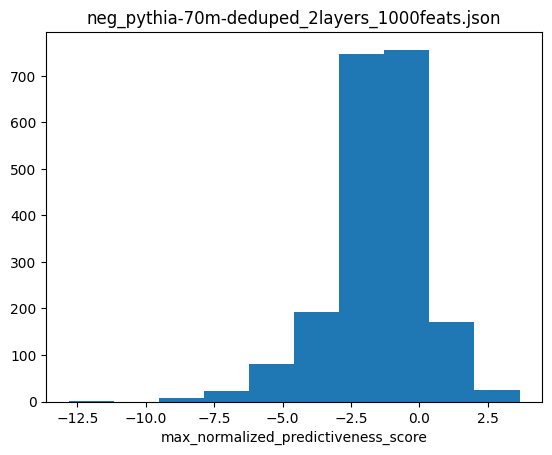

In [27]:
import matplotlib.pyplot as plt
key = "max_normalized_predictiveness_score"
plt.hist(all_df[key].values)
plt.xlabel(key)
plt.title(path.split("/")[-1])
plt.show()